# Placeholders and Variables

### © Jubeen Shah 2018

Hey there! Welcome to `J.S Codes` jupyter notebooks for TensorFlow!
<br>
<img src="image/notmnist.png">

In this lab, you'll use all the tools you've seen from all the previous notebooks in the series, to label images of English letters! The data you are using, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consists of images of a letter from A to J in different fonts.

The above images are a few examples of the data we'll be training on. After training the network, we will compare our prediction model against test data. Our goal, by the end of this notebook, is to make predictions against that test set with at least an 80% accuracy. Let's jump in! 
__¿Estás listo amigo?__

##  Importing the necessary modules

*If the below import statement results in an error, please do the following before proceeding.*

### For Windows Users

__cd__ into the 00_Environments/01_WelcomeToTensorflow folder, then using the Anaconda Prompt for tensorflow execute the following command.

__conda env create -f environment_win.yml __

This would create the required environment for running this notebook. Then you can use __activate js-welcomeToTensorFlow__ command to activate the environment. Or use the GUI to do the same. All the necessary packages should be installed for you.

### For OS X or linux users

__cd__ into the 00_Environments/01_WelcomeToTensorflow folder, then using the Terminal execute the following command.

__conda env create -f environment.yml __

This would create the required environment for running this notebook. Then you can use __source activate js-welcomeToTensorFlow__ command to activate the environment. Or use the GUI to do the same. All the necessary packages should be installed for you.

In [10]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print("Import complete")

Import complete


### Downloading the dataset
The notMNIST dataset is too large for most computers to handle, as it contains well over 500,000 images just for training. We would just be using a subset of 15,000 for each labels(A-J)

#### Note : If the below cell throws error for connectivity issues, use these URLS and save the file in the same place as this notebook.
[notMNIST_train.zip](https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip) <br>
[notMNIST_test.zip](https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip)


In [11]:
# Downloading the dataset

def download(url, file):
    if not os.path.isfile(file):
        print("Downloading " + file + "...")
        urlretrieve(url= url,filename=file)
        print("Download Finished")

download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip','notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip','notMNIST_test.zip')
# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


### Uncompressing the downloaded zip file into features and labels


In [37]:
def uncompress_features_labels(file):
    features = []
    labels = []  
    with ZipFile(file) as zipf:
        filenames_pbar = tqdm(zipf.namelist(), unit = 'files')
        for filename in filenames_pbar:
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    feature = np.array(image, dtype=np.float32).flatten()
                label = os.path.split(filename)[1][0]
                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

        
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

is_feature_normal = False
is_labels_encod = False

print('All features and labels have been uncompressed')

100%|███████████████████████████████████████████████████████████████████████| 10001/10001 [00:01<00:00, 9518.54files/s]


All features and labels have been uncompressed


<img src="image/Mean_Variance_Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">
### Step 1
The first step involves normalizing the features for our training and test data.

We will implement Min-Max scaling in the `normalize_grayscale()` function to a range of `a=0.1` and `b=0.9`. After scaling, the values of the pixels in the input data should range from 0.1 to 0.9.

Since the raw notMNIST image data is in [grayscale](https://en.wikipedia.org/wiki/Grayscale), the current values range from a min of 0 to a max of 255.

Min-Max Scaling:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

In [38]:
# Implementation of min-max scaling

def normalize_grayscale(image_data):
    """
    parameters -- the image data to be normalized
    returns -- Normalized image data
    """
    a = 0.1
    b = 0.9
    
    x_min = 0
    x_max = 255
    
    x = image_data
    
    x_bar = a +                              \
    (                                        \
      (                                      \
        (x - x_min) * (b - a)                \
      )                                      \
        /                                    \
        (x_max - x_min)                      \
    )                                        \
    
    return x_bar


### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_feature_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_feature_normal = True

print('Tests Passed!')

Tests Passed!


In [39]:
print(train_labels)

['A' 'E' 'A' ..., 'F' 'C' 'H']


In [40]:
if not is_labels_encod:
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)
    
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True
print("Labels One-Hot Encoded")

Labels One-Hot Encoded


In [41]:
print(len(train_labels))

150000


In [42]:
assert is_feature_normal, "Normalize the features again"
assert is_labels_encod, "One-hot Encode the labels"

train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size = 0.05,
    random_state = 832289
)
print("Training features and labels randomized and split.")

Training features and labels randomized and split.


In [43]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


# Checkpoint
All our progress is now saved to the pickle file.  If we need to leave and comeback to this notebook, we no longer have to start from the beginning.  We can just run the code block below and it will load all the data and modules required to proceed.

In [1]:
%matplotlib inline

import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.



## Step 2

Now it's time to build a simple neural network using TensorFlow. Here, our network will be just an input layer and an output layer.

<img src="image/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

For the input here the images have been flattened into a vector of $28 \times 28 = 784$ features. Then, we're trying to predict the image digit so there are 10 output units, one for each label. Of course, feel free to add hidden layers if you want, but this notebook is built to guide you through a single layer network. 

For the neural network to train on your data, you need the following <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> for help.
 - `biases`
  - Variable Tensor with all zeros.
    - See <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> for help.

In [4]:
features_count = 28*28
labels_count = 10

In [5]:
features = tf.placeholder(dtype=tf.float32)
labels = tf.placeholder(dtype=tf.float32)

In [7]:
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
bias = tf.Variable(tf.zeros((labels_count)))

### Testing the approach till now.

In [12]:
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a palceholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'Weights must be a TensorFlow Variable'
assert isinstance(bias, Variable), 'biast must be a TensorFlow Variable.'

assert features._shape == None or (\
                                    features._shape.dims[0].value is None and\
                                    features._shape.dims[1].value in [None, 784]), 'The shape of the feaures placeholder is incorrect'
assert labels._shape == None or(\
                               labels._shape.dims[0] is None and\
                               labels._shape.dims[1] in [None, 10]), 'The shape of the labels placeholder is incorrect'

assert weights._variable.shape == (784, 10), 'The shape of the weights variable is incorrect'
assert bias._variable.shape == (10), 'The shape of the bias is incorrect'

assert features._dtype == tf.float32, "The features' data type should be tf.float32"
assert labels._dtype == tf.float32, "The bias' data type should be tf.float32"

print("All tests Passed!")

All tests Passed!


### Setting values using feed_dict

In [24]:
train_feed_dict = {features : train_features, labels: train_labels}
valid_feed_dict = {features : valid_features, labels: valid_labels}
test_feed_dict =  {features: test_features, labels: test_labels}

Calculating the logits using WX + B <br>
*where, <br>
W is the Weights <br>
X is the Features, <br>
B is the Bias * <br>

In [30]:
logits =  tf.matmul(features, weights) + bias


Calculating the softmax from the logits obtained

In [31]:
prediction = tf.nn.softmax(logits=logits)

Calculating the cross entropy <br>
$H(p,q)=-\sum _{x}p(x)\,\log q(x) $


In [32]:
cross_entropy = -1 * tf.reduce_sum(labels * tf.log(prediction), reduction_indices= 1)

In [33]:
training_loss = tf.reduce_mean(cross_entropy)

In [34]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(training_loss, feed_dict = train_feed_dict)
    sess.run(training_loss, feed_dict = valid_feed_dict)
    sess.run(training_loss, feed_dict = test_feed_dict)
    biases_data = sess.run(bias)

assert not np.count_nonzero(biases_data), "Biases must be zeros"

print("Tests passed")

Tests passed


### Determining if the predictions are correct


In [35]:
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels,1))

### Calculating the accuracy

In [36]:
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print("Accuracy funtion created")

Accuracy funtion created


<img src="image/Learn_Rate_Tune_Image.png" style="height: 70%;width: 70%">
## Step 3
Below are 2 parameter configurations for training the neural network. In each configuration, one of the parameters has multiple options. For each configuration, choose the option that gives the best acccuracy.

Parameter configurations:

Configuration 1
* **Epochs:** 1
* **Learning Rate:**
  * 0.8
  * 0.5
  * 0.1
  * 0.05
  * 0.01

Configuration 2
* **Epochs:**
  * 1
  * 2
  * 3
  * 4
  * 5
* **Learning Rate:** 0.2

The code will print out a Loss and Accuracy graph, so we can see how well the neural network performed.

In [80]:
import time
batch_size_list = [128]
epochs_list = [5]
learning_rate_list = [0.21,0.2,0.1, 0.09]
accuracy_list = []
accuracy_dict = {}

Batch Size = 128 Epochs = 5 Learning Rate = 0.21


Epoch  5/5: 100%|████████████████████████████████████████████████████████████| 1114/1114 [00:09<00:00, 113.54batches/s]


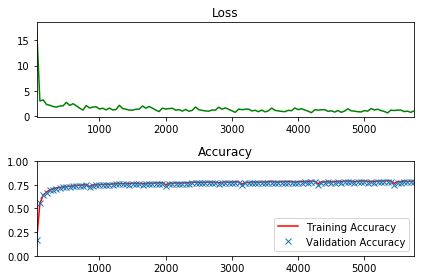

Learning rate =  0.21 Epochs =  5
Validation accuracy at 0.7738666534423828
--- 50.6611864566803 seconds ---
Batch Size = 128 Epochs = 5 Learning Rate = 0.2


Epoch  5/5: 100%|████████████████████████████████████████████████████████████| 1114/1114 [00:10<00:00, 108.74batches/s]


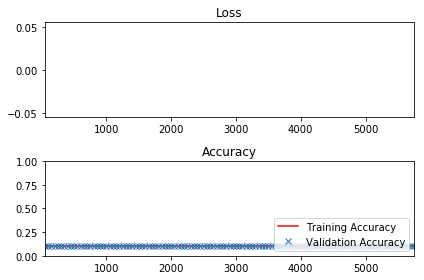

Learning rate =  0.2 Epochs =  5
Validation accuracy at 0.10599999874830246
--- 52.88134956359863 seconds ---
Batch Size = 128 Epochs = 5 Learning Rate = 0.1


Epoch  5/5: 100%|████████████████████████████████████████████████████████████| 1114/1114 [00:09<00:00, 116.82batches/s]


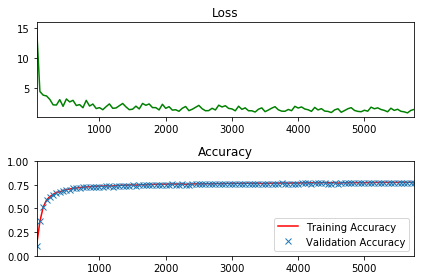

Learning rate =  0.1 Epochs =  5
Validation accuracy at 0.768666684627533
--- 49.73094987869263 seconds ---
Batch Size = 128 Epochs = 5 Learning Rate = 0.09


Epoch  5/5: 100%|████████████████████████████████████████████████████████████| 1114/1114 [00:09<00:00, 111.42batches/s]


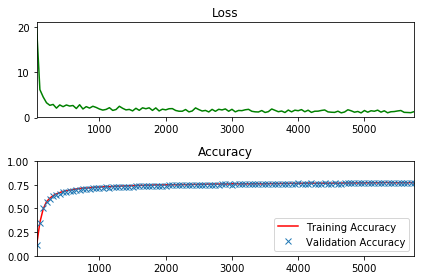

Learning rate =  0.09 Epochs =  5
Validation accuracy at 0.7657333612442017
--- 51.97544074058533 seconds ---


In [81]:
#gradient descent
for batch_size in batch_size_list:
    for epochs in epochs_list:
        for learning_rate in learning_rate_list:
            start_time = time.time()
            print("Batch Size = " + str(batch_size) + " Epochs = " + str(epochs) + " Learning Rate = " + str(learning_rate))
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(training_loss)

            validation_accuracy = 0.0

            log_batch_step = 50
            batches =[]
            loss_batch = []
            train_acc_batch = []
            valid_acc_batch = []

            with tf.Session() as sess:
                sess.run(init)
                batch_count = int(math.ceil(len(train_features)/ batch_size))

                for epochs_i in range(epochs):
                    batches_pbar = tqdm(range(batch_count), desc = 'Epoch {:>2}/{}'.format(epochs_i+1, epochs), unit='batches')

                     # The training cycle
                    for batch_i in batches_pbar:
                        # Get a batch of training features and labels
                        batch_start = batch_i*batch_size
                        batch_features = train_features[batch_start:batch_start + batch_size]
                        batch_labels = train_labels[batch_start:batch_start + batch_size]

                        # Run optimizer and get loss
                        _, l = sess.run(
                            [optimizer, training_loss],
                            feed_dict={features: batch_features, labels: batch_labels})

                        # Log every 50 batches
                        if not batch_i % log_batch_step:
                            # Calculate Training and Validation accuracy
                            training_accuracy = sess.run(accuracy, feed_dict=train_feed_dict)
                            validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)

                            # Log batches
                            previous_batch = batches[-1] if batches else 0
                            batches.append(log_batch_step + previous_batch)
                            loss_batch.append(l)
                            train_acc_batch.append(training_accuracy)
                            valid_acc_batch.append(validation_accuracy)

                    # Check accuracy against Validation data
                    validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)

            loss_plot = plt.subplot(211)
            loss_plot.set_title('Loss')
            loss_plot.plot(batches, loss_batch, 'g')
            loss_plot.set_xlim([batches[0], batches[-1]])
            acc_plot = plt.subplot(212)
            acc_plot.set_title('Accuracy')
            acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
            acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
            acc_plot.set_ylim([0, 1.0])
            acc_plot.set_xlim([batches[0], batches[-1]])
            acc_plot.legend(loc=4)
            plt.tight_layout()
            plt.show()
            print("Learning rate = ", learning_rate, end = "")
            print(" Epochs = ",  epochs)
            print('Validation accuracy at {}'.format(validation_accuracy))
            accuracy_list.append(validation_accuracy)
            time_taken = time.time() - start_time
            accuracy_dict = {validation_accuracy : [learning_rate, epochs,batch_size, time_taken]}
            print("--- %s seconds ---" % (time.time() - start_time))


In [76]:

max_acc = max(accuracy_list)
print(accuracy_dict)
print(accuracy_dict[max_acc])


{0.77013332: [0.2, 5, 128, 51.10089921951294]}
[0.2, 5, 128, 51.10089921951294]


In [82]:
### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  5/5: 100%|████████████████████████████████████████████████████████████| 1114/1114 [00:01<00:00, 926.87batches/s]


Nice Job! Test Accuracy is 0.8431000113487244
